# Tests ForecasterAutoregMultiseries when series have different lengths

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
print(str(Path.cwd().parent.parent))

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
import joblib

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
set_dark_theme()

# Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import ParameterGrid
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Others
# ==============================================================================
import warnings
import sys

print(f"Python version: {sys.version}")
print(f"skforecast version: {skforecast.__version__}")
print(f"lightgbm version: {lightgbm.__version__}")
print(f"sklearn version: {sklearn.__version__}")

/home/ubuntu/varios/skforecast
Python version: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:29:18) [GCC 11.2.0]
skforecast version: 0.12.0
lightgbm version: 3.3.5
sklearn version: 1.3.2


In [2]:
#  todo: media ponderada

# Tes utitario para verificar que nada cambia

In [3]:
# Load time series of multiple lengths
# ==============================================================================
# series_dict = joblib.load('sample_multi_series.joblib')
# exog_dict = joblib.load('sample_multi_series_exog.joblib')

series = pd.read_csv('../fixtures/sample_multi_series.csv')
exog = pd.read_csv('../fixtures/sample_multi_series_exog.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])


series_dict = series_long_to_dict(
    data = series,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

series_dict['id_1002'].at['2016-02-01'] = np.nan
series_dict['id_1002'].at['2016-05-01'] = np.nan
exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

In [4]:
# Partition data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

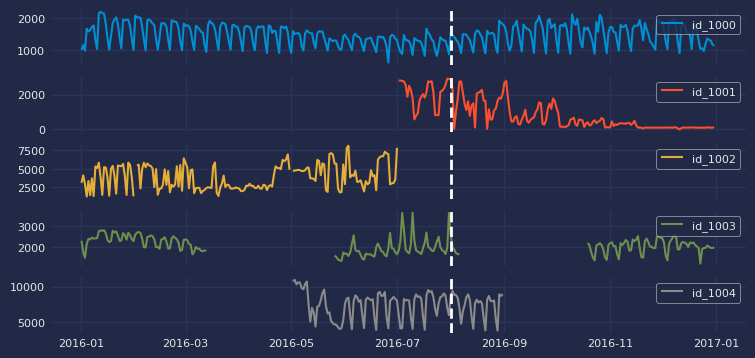

In [5]:
# Plot series
# ==============================================================================
end_train_ts = pd.to_datetime(end_train)    


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    # axs[i].axvline(end_train)
    axs[i].axvline(end_train_ts, color='white', linestyle='--', linewidth=2)

In [6]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [7]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print(f"\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


In [8]:
# Test predict
# ==============================================================================
params = {
    'encoding': ['ordinal', 'onehot', 'ordinal_category'],
    'dropna_from_series': [False, True],
    'interval': [[5, 95]],
    'n_boot': [10]
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")

    forecaster = ForecasterAutoregMultiSeries(
                    regressor=LGBMRegressor(n_estimators=2, random_state=123, verbose=-1, max_depth=2),
                    lags=14,
                    encoding=params['encoding'],
                    dropna_from_series=params['dropna_from_series'],
                    transformer_series=StandardScaler(),
                    transformer_exog=StandardScaler()            
                )
    forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
    predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
    predictions_int = forecaster.predict_interval(
        steps=5, exog=exog_dict_test, interval=params['interval'], n_boot=params['n_boot'], suppress_warnings=True
    )

Paramns: {'dropna_from_series': False, 'encoding': 'ordinal', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': False, 'encoding': 'onehot', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': False, 'encoding': 'ordinal_category', 'interval': [5, 95], 'n_boot': 10}
Paramns: {'dropna_from_series': True, 'encoding': 'ordinal', 'interval': [5, 95], 'n_boot': 10}


ValueError: a cannot be empty unless no samples are taken

In [9]:
# Test backtesting
# ==============================================================================
params = {
    'initial_train_size': [50, len(series_dict_train['id_1000'])],
    'refit' : [True, False, 2],
    'fixed_train_size': [True, False],
    'gap': [0, 7],
    'levels': [None, ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'id_1000', ['id_1000', 'id_1001']],
    'metrics': [['mean_absolute_error', 'mean_squared_error'], 'mean_absolute_error'],
    'allow_incomplete_fold': [True, False],
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")

    forecaster = ForecasterAutoregMultiSeries(
        regressor=LGBMRegressor(n_estimators=2, random_state=123, verbose=-1, max_depth=2),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler()
    )

    metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series_dict,
        exog                  = exog_dict,
        levels                = params['levels'],
        steps                 = 24,
        metric                = params['metrics'],
        initial_train_size    = params['initial_train_size'],
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = params['allow_incomplete_fold'],
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1003' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecas

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/va

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1003' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/va

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': 2}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not prese

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': None, 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not prese

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': None, 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not prese

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004'], 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not prese

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': 'id_1000', 'metrics': 'mean_absolute_error', 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': ['mean_absolute_error', 'mean_squared_error'], 'refit': 2}
Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': True}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': False}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000'

Paramns: {'allow_incomplete_fold': True, 'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'levels': ['id_1000', 'id_1001'], 'metrics': 'mean_absolute_error', 'refit': 2}


KeyboardInterrupt: 

In [10]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1, max_depth=2),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),
                transformer_exog=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

def search_space(trial):
    search_space  = {
        "n_estimators": trial.suggest_int("n_estimators", 2, 5),
        "max_depth": trial.suggest_int('max_depth', 2, 5),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning, module='optuna')

    results_search_1, best_trial_1 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series,
        exog               = exog,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_dict_train['id_1000']),
        steps              = 10,
        refit              = False,
        n_trials           = 3,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

[W 2024-04-10 18:27:46,316] Trial 0 failed with parameters: {'n_estimators': 4, 'max_depth': 3, 'lags': [1, 7, 14]} because of the following error: TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''").
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/skforecast_12_py12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py", line 1591, in _objective
    metrics_levels = backtesting_forecaster_multiseries(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py", line 790, in backtesting_forecaster_multiseries
    metrics_levels, backtest_predict

Number of models compared: 3,
         3 bayesian search in each lag configuration.


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Test Grid Search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1, max_depth=2),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),
                transformer_exog=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [10, 20],
    "max_depth": [2, 5],
}


results_search_1 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series,
    exog               = exog,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_dict_train['id_1000']),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)

In [50]:
# Last execution
# ==============================================================================
print(f"Last execution: {pd.Timestamp.now()}")

Last execution: 2024-04-05 22:49:23.163444
